In [ ]:
import json
import pandas as pd

In [ ]:
data = "data/train_data_3_pos_3_neg_10000_req_parsed.json"

In [ ]:
with open(data, 'r') as f:    
    entries = [json.loads(line) for line in f.readlines()]

In [ ]:
entries[0].keys()

dict_keys(['astask', 'profile', 'label'])

In [ ]:
train_df = pd.DataFrame(entries, columns=entries[0].keys())

In [ ]:
train_df

,astask,profile,label
0,"titles: ['plant manager', 'manufacturing manag...",title: ['plant manager']\nyears: 20+\nlocation...,1
1,"titles: ['plant manager', 'manufacturing manag...",title: ['plant manager']\nyears: 20+\nlocation...,1
2,"titles: ['plant manager', 'manufacturing manag...",title: ['plant manager']\nyears: 10-15\nlocati...,1
3,"titles: ['plant manager', 'manufacturing manag...",title: ['plant manager']\nyears: 10-15\nlocati...,0
4,"titles: ['plant manager', 'manufacturing manag...",title: ['plant manager']\nyears: 20+\nlocation...,0
...,...,...,...
59995,"titles: ['java'], exp_years: ['4-6', '6-8', '8...",title: ['developer']\nyears: 10-15\nlocation: ...,1
59996,"titles: ['java'], exp_years: ['4-6', '6-8', '8...",years: 10-15\nlocation: colombia\ncompany size...,1
59997,"titles: ['java'], exp_years: ['4-6', '6-8', '8...",title: ['development team leader']\nyears: 8-1...,0
59998,"titles: ['java'], exp_years: ['4-6', '6-8', '8...",title: ['backend developer']\nyears: 4-6\nloca...,0


In [ ]:
train_df['jd_reusme'] = train_df['astask'] + "\n" + train_df['profile']
train_df = train_df.dropna(axis=0)

60000
60000


In [ ]:
from transformers import GPT2Tokenizer

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [ ]:
text = "This is an example sentence."
encoded_text = tokenizer.encode(text)
token_count = len(encoded_text)

print(f"Token count: {token_count}")

Token count: 6


In [ ]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
def count_tokens(text):
    encoded_text = tokenizer.encode(text)
    return len(encoded_text)

In [ ]:
train_df["token_count"] = train_df["jd_reusme"].apply(count_tokens)

Token indices sequence length is longer than the specified maximum sequence length for this model (1047 > 1024). Running this sequence through the model will result in indexing errors


In [ ]:
import matplotlib.pyplot as plt

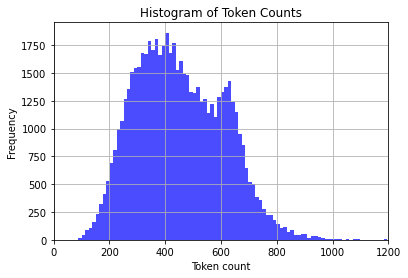

In [ ]:
plt.hist(train_df["token_count"], bins='auto', alpha=0.7, color='blue')
plt.xlabel("Token count")
plt.ylabel("Frequency")
plt.title("Histogram of Token Counts")
plt.grid(True)
plt.xlim((0,1200))
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_data, valid_data = train_test_split(train_df, test_size=0.1, random_state=42)

In [ ]:
valid_data

,astask,profile,label,jd_reusme,token_count
12628,"titles: ['android developer', 'android applica...",title: ['ios application developer']\nyears: 6...,0,"titles: ['android developer', 'android applica...",378
37730,"titles: ['financial business analyst', 'busine...",title: ['financial analyst']\nyears: 6-8\nloca...,1,"titles: ['financial business analyst', 'busine...",489
39991,"titles: ['chief revenue officer'], exp_years: ...",title: ['chief revenue officer']\nyears: 20+\n...,1,"titles: ['chief revenue officer'], exp_years: ...",636
8525,"titles: ['strategy analyst - remote', 'strateg...",title: ['associate']\nyears: 2-4\nlocation: ch...,0,"titles: ['strategy analyst - remote', 'strateg...",454
8279,"titles: ['controls technician'], mandatory_ski...",title: ['building engineer']\nyears: 4-6\nloca...,0,"titles: ['controls technician'], mandatory_ski...",402
...,...,...,...,...,...
44157,"titles: ['asset manager', 'assistant asset man...","title: ['asset management', 'technician']\nyea...",0,"titles: ['asset manager', 'assistant asset man...",461
24898,"titles: ['lead'], mandatory_skills: ['clinical...","years: 20+\nlocation: madera, california, unit...",0,"titles: ['lead'], mandatory_skills: ['clinical...",305
6528,"titles: ['finance', 'accountant', 'controller'...",title: ['office manager']\nyears: 10-15\nlocat...,1,"titles: ['finance', 'accountant', 'controller'...",231
20395,"titles: ['manager', 'accounting manager', 'aud...","title: ['supervisor', 'assurance']\nyears: 4-6...",1,"titles: ['manager', 'accounting manager', 'aud...",392


In [ ]:
import pandas as pd

In [ ]:
data = "data/train_data_01_4_200.csv"

In [ ]:
train_df = pd.read_csv(data, delimiter="$")

In [ ]:
train_df.head(64).to_csv('data/small.csv', sep='$', index=False)

In [ ]:
train_df.index.size

44460

In [ ]:
train_df['jd_reusme'] = train_df['query'] + "\n" + train_df['resume']
train_df = train_df.dropna(axis=0)

In [ ]:
nan_age_df = train_df[train_df['jd_reusme'].isna()]
nan_age_df

,search_id,query,resume,label,jd_reusme


In [ ]:
train_data, valid_data = train_test_split(train_df, test_size=0.2, random_state=42)
train_texts, train_labels = train_data['jd_reusme'].tolist(), train_data['label'].tolist()
valid_texts, valid_labels = valid_data['jd_reusme'].tolist(), valid_data['label'].tolist()

NameError: name 'train_test_split' is not defined

In [ ]:
tokenizer = LlamaTokenizer.from_pretrained("/home/ubuntu/ranking_llama/weights/tokenizer/")
tokenizer.add_special_tokens({"pad_token": "<pad>"})

1

In [ ]:
MAX_LENGTH = 512
train_dataset = BinaryClassificationDataset(train_data, tokenizer, max_length=MAX_LENGTH)
valid_dataset = BinaryClassificationDataset(valid_data, tokenizer, max_length=MAX_LENGTH)

In [ ]:
batch_size=1
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

In [ ]:
# for i, batch in enumerate(train_dataloader):
#     print(f"Batch {i}: {batch}")
#     break